# Introduction to chemoinformatics

What we'll cover in this lecture:

- Representation of molecules
- 2D fingerprints
- Molecular similarities
- Virtual screening
- Substructure search
- Machine learning (prioritization, clustering, QSAR models)

## Representation of molecules

- Connection tables (graph-based with 3D coords): MDL
- String-based: SMILES, InChI

Detailed rules for SMILES strings:
https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html

In [1]:
%pylab inline

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdFMCS
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage, DrawMorganBit, DrawMorganBits, SimilarityMaps

import py3Dmol
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


RDKit WARNING: [13:00:51] Enabling RDKit 2019.09.3 jupyter extensions


## SMILES strings in practice

Let's see some examples:

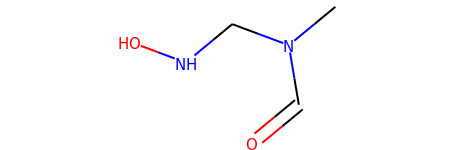

In [2]:
Chem.MolFromSmiles("CN(C=O)CNO") # ethanol

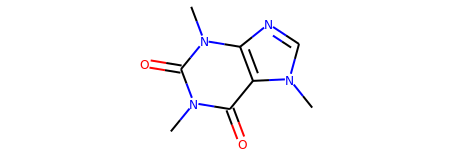

In [3]:
Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C") # caffeine

## 3D embeddings from SMILES strings

There are a couple of challenges:
- Calculation of coordinates takes a lot of resources (molecular dynamics simulations and force field-based optimization)
- Hard to find all energetically feasible conformations (or a set diverse enough to contain relevant ones)
- Need to match experimental observations
- (Active conformation may not be a low-energy one!)

Distance geometry:
- Distance bounds for all pairs of atoms
- Satisfy constraints via a genetic algorithm
- Can yield distorted rings and weird torsion angles

ETKDG algorithm: distance geometry + chemical (experimental) knowledge

In [4]:
mol = Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")
mol = Chem.AddHs(mol)

cids = AllChem.EmbedMultipleConfs(mol,numConfs=100)
rms = []
AllChem.AlignMolConformers(mol,RMSlist=rms)

In [5]:
v = py3Dmol.view(300,300)
#v.addModel(Chem.MolToMolBlock(mol,confId=int(np.argmax(rms))))
v.addModel(Chem.MolToMolBlock(mol,confId=0))
v.setStyle({'stick':{}})
v.render()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Databases

- ChEMBL, PubChem, DrugBank etc.
- Open PHACTS: https://www.openphactsfoundation.org/

In [6]:
df = pd.read_csv("mols.txt",sep='\t')
df.head(5)

,name,SMILES
0,granisetron,CN1N=C(C(=O)NC2CC3CCCC(C2)N3C)C2=CC=CC=C12
1,dienestrol,CC=C(C(=CC)C1=CC=C(O)C=C1)C1=CC=C(O)C=C1
2,sulfapyridine,NC1=CC=C(C=C1)S(=O)(=O)NC1=CC=CC=N1
3,rimexolone,CCC(=O)[C@@]1(C)[C@H](C)CC2C3CCC4=CC(=O)C=C[C@...
4,triazolam,CC1=NN=C2CN=C(C3=CC=CC=C3Cl)C3=C(C=CC(Cl)=C3)N12


## ECFP fingerprints

- For each atom, compute Daylight atomic invariants (#neighbors, #bonds, #H, atomic number and mass, ring membership)
- Hash into an integer (identifier)
- Create new hash for each atom from the identifiers of all atoms in the neighborhood of diameter 1
- Update identifiers, delete duplicates
- Repeat with increasing diameters 2-4
- Create a bit vector by setting bits corresponding to all previous identifiers and fold it

![](fp.svg)

In [7]:
mol  = Chem.MolFromSmiles("CC(C=O)N")
info = {}
fp   = AllChem.GetMorganFingerprintAsBitVect(mol,2,bitInfo=info)

In [8]:
info

{1: ((1, 0),),
 43: ((1, 1),),
 283: ((0, 1),),
 508: ((2, 1),),
 650: ((3, 0),),
 694: ((2, 0),),
 786: ((4, 1),),
 1004: ((3, 1),),
 1057: ((0, 0),),
 1171: ((4, 0),),
 1329: ((2, 2),)}

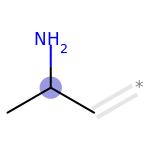

In [10]:
DrawMorganBit(mol,43,info)

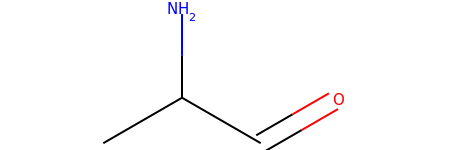

In [11]:
mol

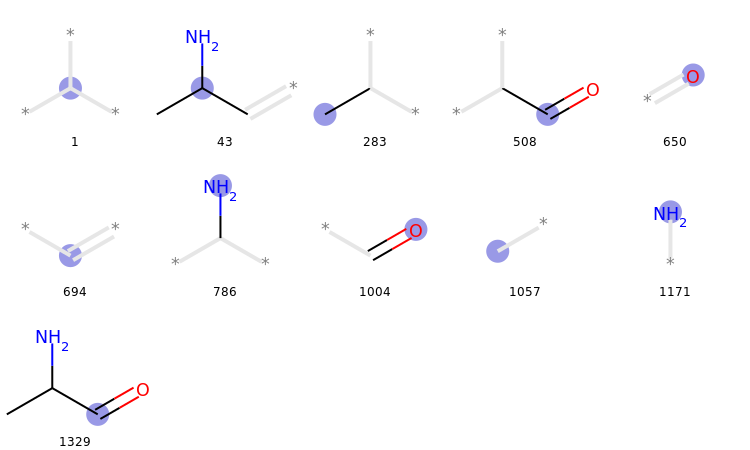

In [12]:
tpls = [(mol,x,info) for x in fp.GetOnBits()]
DrawMorganBits(tpls,molsPerRow=5,legends=[str(x) for x in fp.GetOnBits()])

In [13]:
mols,names,fps,pos = [],[],[],{}
for i,data in df.iterrows():
    name,smiles = data

    mol   = Chem.MolFromSmiles(smiles)
    fp    = AllChem.GetMorganFingerprintAsBitVect(mol,2)
    arr   = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp,arr)

    mols  += [mol]
    names += [name]
    fps   += [arr]
    pos[name] = i

fps   = array(fps)
names = array(names)
mols  = array(mols)

In [14]:
print(names[0],fps[0])
print(names[1],fps[1])

granisetron [0. 1. 0. ... 0. 0. 0.]
dienestrol [0. 0. 0. ... 0. 0. 0.]


## Molecular similarities

*Similar Property Principle: similar compounds tend to have have similar properties.*

Some measures of similarity:

- Cosine: $\cos(x,y) = \frac{x \cdot y}{\left|x \right| \left|y \right|},$ which equals $1$ if the two molecules have the same fingerprints.
- Tanimoto similarity: $T(x,y) = \frac{x \cdot y}{\left|x \right|^2 + \left|y \right|^2 - x \cdot y}$.

Let's create a similarity matrix.

In [15]:
N  = len(fps)
x2 = fps @ fps.T
xd = np.diag(x2)
K  = x2 / ( np.outer(xd,np.ones(N)) + np.outer(np.ones(N),xd) - x2)

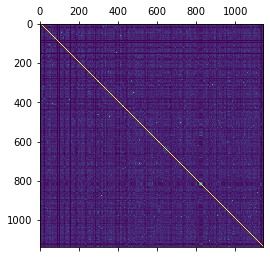

In [16]:
matshow(K);

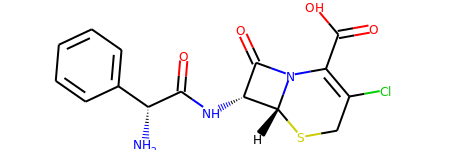

In [17]:
mols[pos["cefaclor"]]

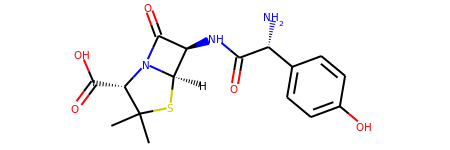

In [18]:
mols[pos["amoxicillin"]]

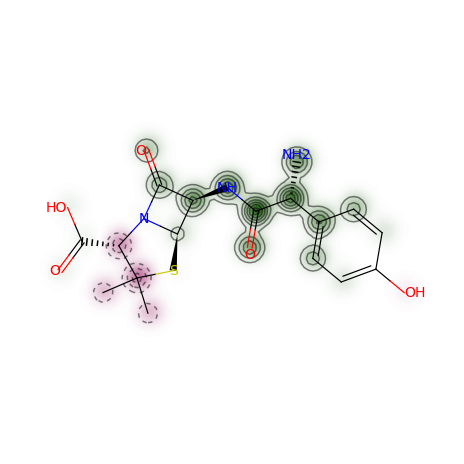

In [19]:
fig,_ = SimilarityMaps.GetSimilarityMapForFingerprint(
    mols[pos["cefaclor"]], mols[pos["amoxicillin"]],
    lambda m,idx: SimilarityMaps.GetMorganFingerprint(m,idx,2),
    metric=DataStructs.TanimotoSimilarity)

## Ligand-based virtual screening (VS)

- Goal: find "active" compounds in huge molecular libraries (chemical space: $\sim 10^{60}$ compounds).
- Idea: find compounds similar to known actives.
- (Other methods: HTS, docking, hybrid approaches)

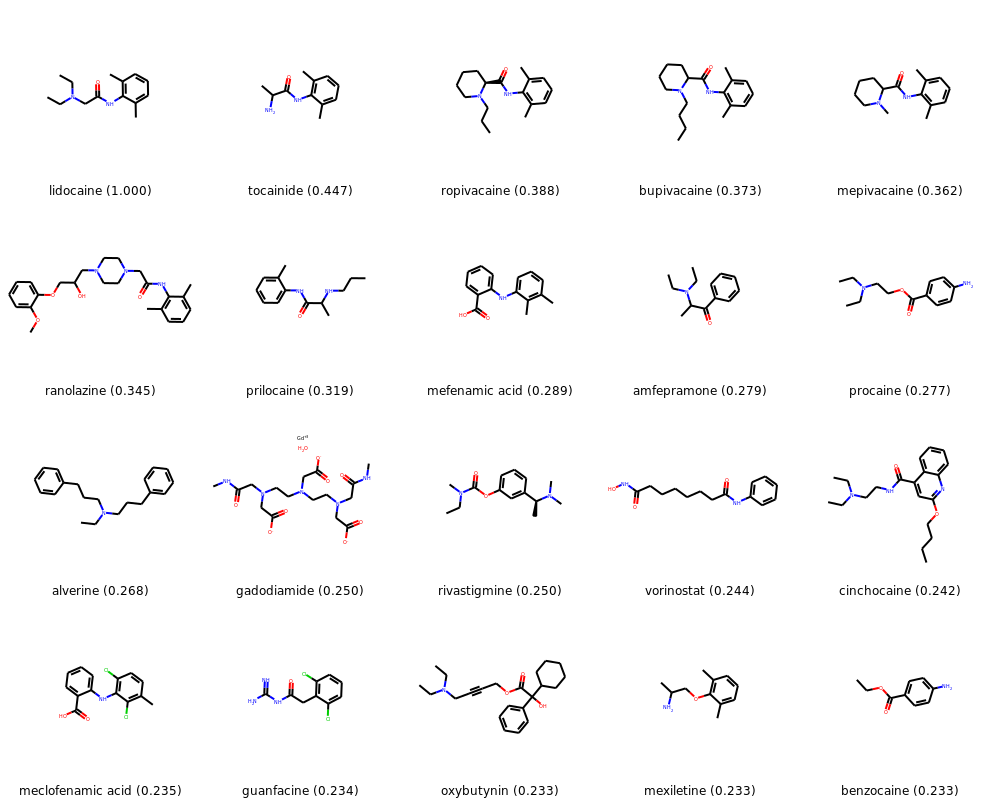

In [20]:
mol  = "lidocaine"
srt  = np.argsort(-K[pos[mol]])[:20]
mgrp = [mols[s]  for s in srt]
mnm  = ["{} ({:.3f})".format(names[s],K[pos[mol],s]) for s in srt]
MolsToGridImage(mgrp, molsPerRow=5, legends = mnm, useSVG=False)

## Substructure search

- It is often useful to look for certain structural features in a large number of molecules
- SMARTS: SMILES arbitrary target specification (SMILES + wildcards, logic rules)

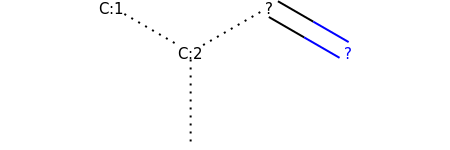

In [21]:
Chem.MolFromSmarts( '[cH0:1][c:2]([cH0])!@[CX3!r:3]=[NX2!r:4]' )

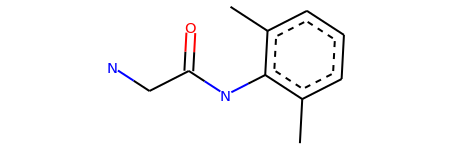

In [22]:
# Find common substructure
smarts = Chem.rdFMCS.FindMCS(mgrp[:5]).smartsString
mcs = Chem.MolFromSmarts(smarts)
mcs

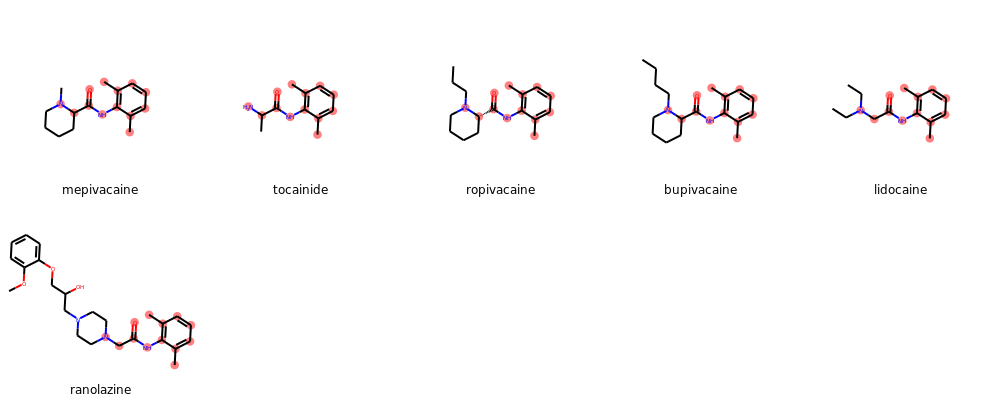

In [23]:
mgrp,mnm = [],[]
for i in range(N):
    if mols[i].HasSubstructMatch(mcs):
        mgrp += [mols[i]]
        mnm  += [names[i]]

AllChem.Compute2DCoords(mcs)
for m in mgrp:
    AllChem.GenerateDepictionMatching2DStructure(m,mcs)
matches = [m.GetSubstructMatch(mcs) for m in mgrp]
MolsToGridImage(mgrp,molsPerRow=5,legends=mnm,useSVG=False,
                highlightAtomLists=matches)

## Machine learning

Here we investigate:
- Clustering of molecules (grouping based on their similarities)
- Multi-ligand virtual screening using SVMs
- Drug-target interaction prediction using matrix factorization

## Clustering

In [24]:
from sklearn.cluster import SpectralClustering
cl = SpectralClustering(200,affinity="precomputed").fit_predict(K)

In [25]:
ind = cl == cl[pos["ibuprofen"]]
print(names[ind])

['naproxen' 'ibuprofen' 'tiaprofenic acid' 'flurbiprofen' 'ketoprofen'
 'fenoprofen' 'suprofen']


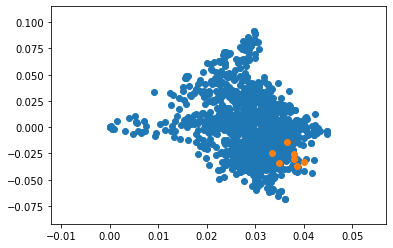

In [26]:
from sklearn.utils.extmath import randomized_svd
U,D,V = randomized_svd(K,2)
scatter(V[0,~ind],V[1,~ind])
scatter(V[0,ind],V[1,ind]);

## Multi-ligand similarity search (group fusion)

![](hypersphere.png)

In [27]:
from sklearn.svm import OneClassSVM

query = ["paroxetine","fluoxetine","sertraline"]
qp    = [pos[q] for q in query]

svm = OneClassSVM(kernel="precomputed").fit(K[qp][:,qp])

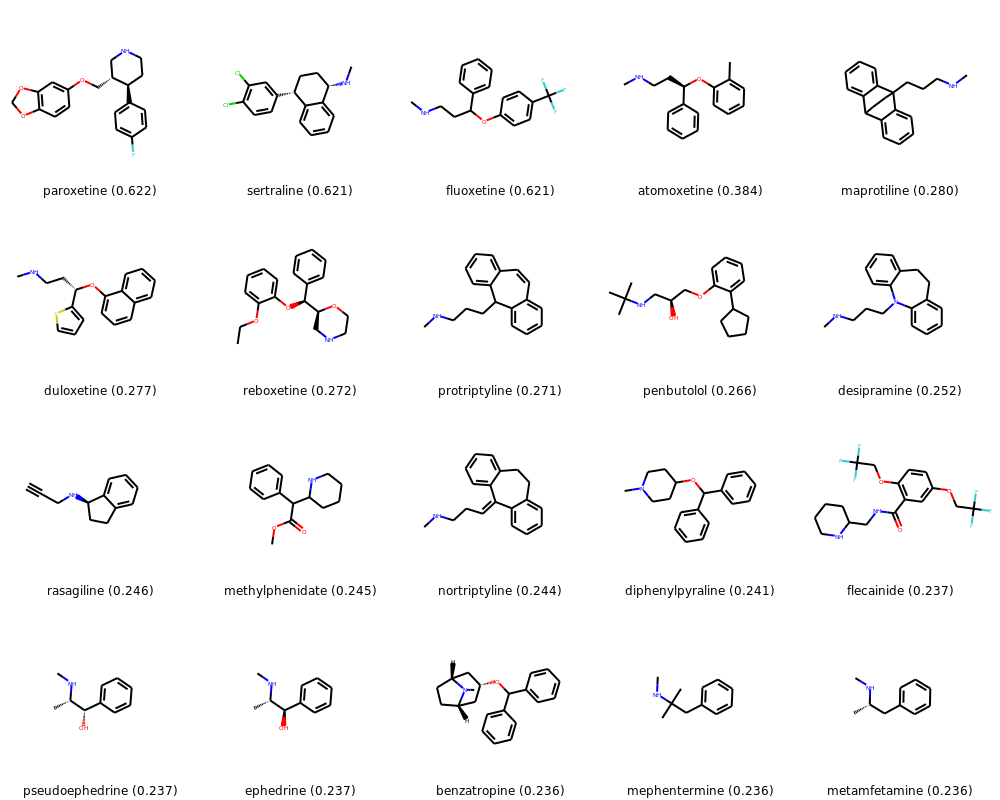

In [28]:
scores = (svm.decision_function(K[:,qp]) - svm.intercept_).flatten()
srt  = np.argsort(-scores)[:20]
mgrp = [mols[s]  for s in srt]
mnm  = ["{} ({:.3f})".format(names[s],scores[s]) for s in srt]
MolsToGridImage(mgrp, molsPerRow=5, legends = mnm, useSVG=False)

## Drug-target interaction prediction

![](mf_side.svg)

In [29]:
data = pd.read_csv("dti.txt",index_col=0,delimiter='\t')
data.head(5)

,D00035,D00110,D00136,D00195,D00219,D00225,D00227,D00228,D00234,D00252,...,D04985,D04999,D05024,D05077,D05156,D05453,D05458,D05461,D06106,D06172
hsa10008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hsa10060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hsa10369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hsa1080,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hsa11254,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
def sigmoid(a):
    ena = np.exp(-np.abs(a))
    return np.where(a>0,1/(1+ena),ena/(1+ena))

In [31]:
def factorize(R,L,iters=200):
    I,J = R.shape
    U = np.random.randn(L,I)
    V = np.random.randn(L,J)

    for iter in range(200):
        S  = sigmoid(U.T @ V)
        U += 0.01 * V @ (R-S).T

        S  = sigmoid(U.T @ V)
        V += 0.01 * U @ (R-S)
        
    return U,V,sigmoid(U.T@V)

In [32]:
R = data.values

Accuracy: 97.955%


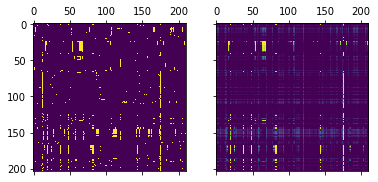

In [33]:
U,V,P = factorize(R,2)
print("Accuracy: {:.3%}".format(np.mean(R == (P>.5))))
f,ax = subplots(1,2,sharex=True,sharey=True)
ax[0].matshow(R);
ax[1].matshow(sigmoid(U.T @ V));

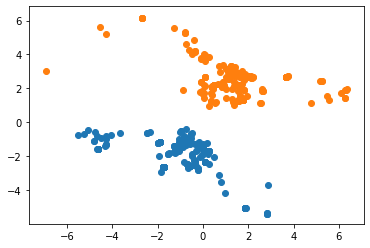

In [34]:
scatter(U[0],U[1])
scatter(V[0],V[1]);

Accuracy: 98.840%


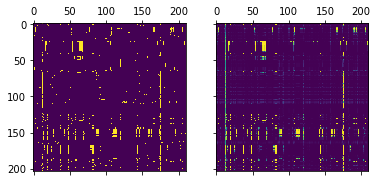

In [35]:
U,V,P = factorize(R,3)
print("Accuracy: {:.3%}".format(np.mean(R == (P>.5))))
f,ax = subplots(1,2,sharex=True,sharey=True)
ax[0].matshow(R);
ax[1].matshow(sigmoid(U.T @ V));

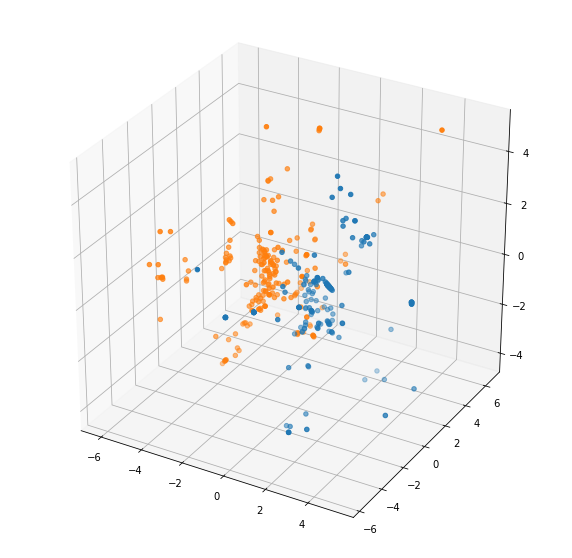

In [36]:
f  = figure(figsize=(10,10))
ax = f.add_subplot(111,projection='3d')

ax.scatter(U[0],U[1],U[2])
ax.scatter(V[0],V[1],V[2]);